# Goal

Save reorient

# Imports

In [1]:
# NYU
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"

In [2]:
# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

In [3]:
import os

# Paths to (1) code (2) data (3) saved models (4) saved metadata
deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"

# saved models, dset metadata
label_src   = f"{data_src}/PitMRdata/samir_labels"
model_src  = f"{data_src}/saved_models"
dsetmd_src = f"{data_src}/saved_dset_metadata"

# dsets
dsets_src    = f"{data_src}/PitMRdata"

# key,val = dset_name, path to top level dir
dset_dict = {
    "ABIDE"                  : f"{dsets_src}/ABIDE",
    "ABVIB"                  : f"{dsets_src}/ABVIB/ABVIB",
    "ADNI1_Complete_1Yr_1.5T": f"{dsets_src}/ADNI/ADNI1_Complete_1Yr_1.5T/ADNI",
    "AIBL"                   : f"{dsets_src}/AIBL/AIBL",
    "ICMB"                   : f"{dsets_src}/ICMB/ICBM",
    "PPMI"                   : f"{dsets_src}/PPMI/PPMI",
}

# print
print("Folders in dset src: ", end=""); print(*os.listdir(dsets_src), sep=", ")

Folders in dset src: ADNI1_full.zip, ABVIB_49_235.zip, AIBL_2-263.zip, ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, ICMB_1005-1297.zip, ABVIB_full.zip, AIBL_full.zip, AIBL, CPTAC-GBM, PPMI_3107-3326.zip, ADNI1_002_0023.zip, ICMB_full.zip, TCGA-LGG, PPMI_full.zip, ABVIB, ABIDE, AIBL.zip


# Imports

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# imports

# Utilities
import os, sys, time, pickle
import glob, re
from pathlib import Path
# sys.path.append('/gpfs/home/gologr01/DeepPit')
# sys.path.append('/gpfs/home/gologr01/OBELISK')

# Numpy torch pandas
import torch

# imports
import SimpleITK as sitk
import meshio
from helpers.preprocess import seg2mask, get_data_dict

# MR data

In [37]:
#dset_name = "PPMI" #"AIBL" #"ABVIB" #"ICMB" # "AIBL" # "ABVIB" #PPMI
#dset_src  = dset_dict[dset_name]

all_fnames = []

for dset_name in dset_dict.keys():
    with open(f"{dsetmd_src}/{dset_name}_fnames.txt", "rb") as f:
        all_fnames += pickle.load(f)

fnames = all_fnames
# load files
# with open(f"{dsetmd_src}/{dset_name}_dset_metadata.pkl", "rb") as f:
#     q_t1 = pickle.load(f)

# with open(f"{dsetmd_src}/{dset_name}_fnames.txt", "rb") as f:
#     fnames = pickle.load(f)

In [6]:
print(dset_name, len(fnames)) #, *fnames, sep="\n")

PPMI 6862


# Check process works

In [6]:
# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

In [8]:
from helpers.items_constants import *

Cross
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/PPMI_full
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ICMB_full
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ADNI1_full
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/AIBL_full
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ABVIB_full
**************************************************
Abide
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153
missing  /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453
missing  /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/503

In [10]:
# Get data dict
data = {}
folders = abide_lbl_folders
for folder in folders: data.update(get_data_dict_n4(folder))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())

In [19]:
# fname1 = '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50327/MP-RAGE/2000-01-01_00_00_00.0/S165359/ABIDE_50327_MRI_MP-RAGE_br_raw_20120830231312523_S165359_I329369_corrected_n4.nii'
# seg1   = '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50327/seg.pt'

('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50030/MP-RAGE/2000-01-01_00_00_00.0/S165371/ABIDE_50030_MRI_MP-RAGE_br_raw_20120830231938380_S165371_I329381_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50030/seg.pt')
inputImage (176, 256, 256)
inputMask torch.Size([176, 256, 256])
Input: dir (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0), Ori LAS
Input: dir (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0), Ori LAS
correctedImage (256, 176, 256)
correctedMask (256, 176, 256)
Input: dir (0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0), Ori SRA
Input: dir (0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0), Ori SRA
Post Set Direction
Input: dir (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0), Ori LAS
Input: dir (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0), Ori LAS
False
1: 
Bbox coords: (72, 133, 89) to (107, 160, 115). Size: 35, 27, 26.
Bounding box coord: from location (133, 89) of slice 72 to location (160, 

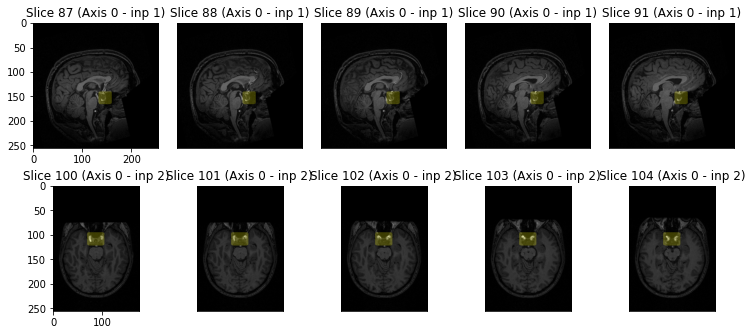

1: 
Bbox coords: (72, 133, 89) to (107, 160, 115). Size: 35, 27, 26.
Bounding box coord: from location (133, 89) of slice 72 to location (160, 115) of slice 107.
2: 
Bbox coords: (89, 69, 133) to (115, 104, 160). Size: 26, 35, 27.
Bounding box coord: from location (69, 133) of slice 89 to location (104, 160) of slice 115.


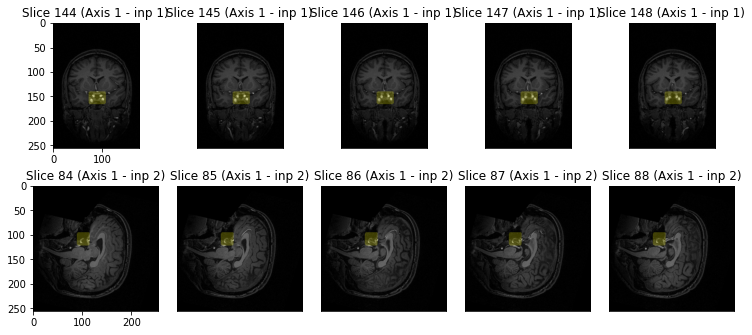

1: 
Bbox coords: (72, 133, 89) to (107, 160, 115). Size: 35, 27, 26.
Bounding box coord: from location (133, 89) of slice 72 to location (160, 115) of slice 107.
2: 
Bbox coords: (89, 69, 133) to (115, 104, 160). Size: 26, 35, 27.
Bounding box coord: from location (69, 133) of slice 89 to location (104, 160) of slice 115.


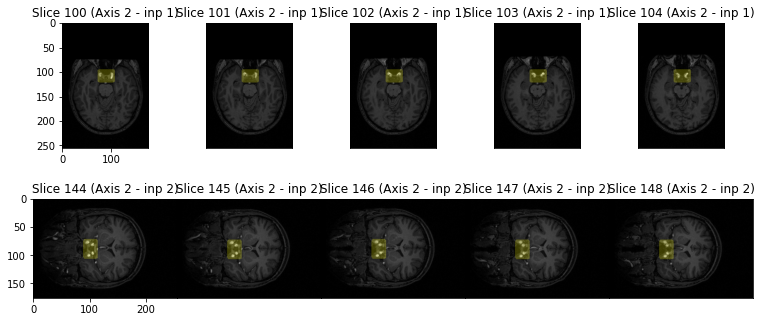

In [58]:
# i = 3
# weirds = ['50013', '50024', '50027', '50030', '50046', '50116', '50132', '50155', '50164', '50208', '50307', '50309', '50343', '50373', '50403', '50415', '50418', '50424']

# weird = weirds[i]

# def get_folder(fn): return re.search("\/(\d+)\/", fn).groups(0)[0]

# weird_item = [item for item in items if get_folder(item[0]) == weird][0]
# fname1, seg1 = weird_item
# print(weird_item)

# inputImage = sitk.ReadImage(fname1, sitk.sitkFloat32)

# # inputMask
# mk_arr = torch.load(seg1).float()
# print("inputImage", inputImage.GetSize())
# print("inputMask", mk_arr.shape)

# mk = sitk.GetImageFromArray(torch.transpose(mk_arr, 0, 2))
# mk.SetOrigin(inputImage.GetOrigin())
# mk.SetSpacing(inputImage.GetSpacing())
# mk.SetDirection(inputImage.GetDirection())

# def print_dir_ori(im):
#     orient    = sitk.DICOMOrientImageFilter()
#     input_dir = im.GetDirection()
#     input_ori = orient.GetOrientationFromDirectionCosines(input_dir)
#     print(f"Input: dir {input_dir}, Ori {input_ori}")
          
# # print orig dir
# print_dir_ori(inputImage)
# print_dir_ori(mk)
          
# # correct
# corrected_image = sitk.DICOMOrient(inputImage, "SRA")
# corrected_mask  = sitk.DICOMOrient(mk, "SRA")

# print("correctedImage", corrected_image.GetSize())
# print("correctedMask", corrected_mask.GetSize())

# # print output
# print_dir_ori(corrected_image)
# print_dir_ori(corrected_mask)

# corrected_image.SetDirection(inputImage.GetDirection())
# corrected_mask.SetDirection(inputImage.GetDirection())

# # print output
# print("Post Set Direction")
# print_dir_ori(corrected_image)
# print_dir_ori(corrected_mask) 

# # check if arr's eq
# import torch
# import numpy as np
# arr1 = np.asarray(torch.transpose(torch.tensor(sitk.GetArrayFromImage(inputImage)), 0, 2))
# arr2 = np.asarray(torch.transpose(torch.tensor(sitk.GetArrayFromImage(corrected_image)), 0, 2))

# mk1 = np.asarray(torch.transpose(torch.tensor(sitk.GetArrayFromImage(mk)), 0, 2))
# mk2 = np.asarray(torch.transpose(torch.tensor(sitk.GetArrayFromImage(corrected_mask)), 0, 2))

# print(np.array_equal(arr1, arr2))

# from helpers.viz import viz_compare_inputs

# input1 = (arr1, mk1)
# input2 = (arr2, mk2)

# for axis in range(3):
#     viz_compare_inputs(input1, input2, axis=axis)

In [51]:
# # save
# # write image
# sitk.WriteImage(corrected_image, fname1)    
# torch.save(torch.tensor(mk2).long(), seg1) 

1: 
Bbox coords: (40, 126, 111) to (63, 153, 132). Size: 23, 27, 21.
Bounding box coord: from location (126, 111) of slice 40 to location (153, 132) of slice 63.
2: 
Bbox coords: (111, 49, 126) to (132, 72, 153). Size: 21, 23, 27.
Bounding box coord: from location (49, 126) of slice 111 to location (72, 153) of slice 132.


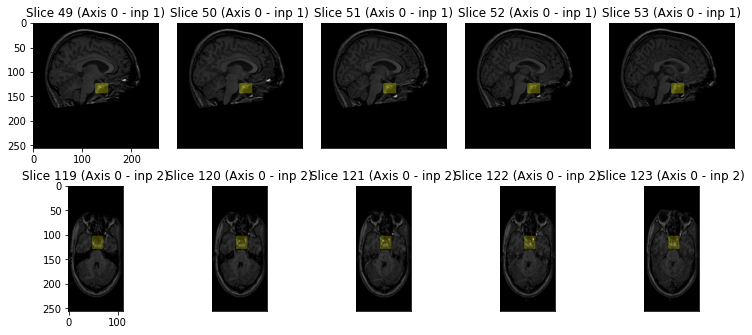

1: 
Bbox coords: (40, 126, 111) to (63, 153, 132). Size: 23, 27, 21.
Bounding box coord: from location (126, 111) of slice 40 to location (153, 132) of slice 63.
2: 
Bbox coords: (111, 49, 126) to (132, 72, 153). Size: 21, 23, 27.
Bounding box coord: from location (49, 126) of slice 111 to location (72, 153) of slice 132.


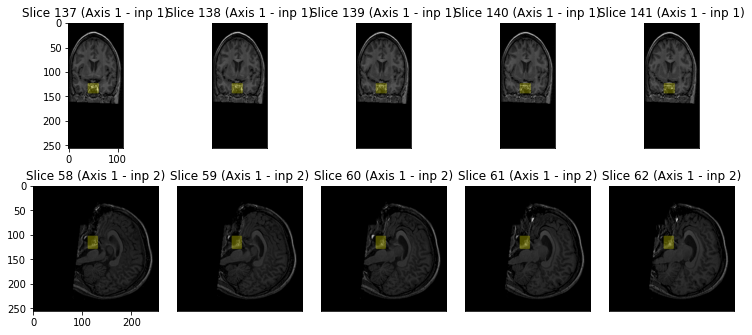

1: 
Bbox coords: (40, 126, 111) to (63, 153, 132). Size: 23, 27, 21.
Bounding box coord: from location (126, 111) of slice 40 to location (153, 132) of slice 63.
2: 
Bbox coords: (111, 49, 126) to (132, 72, 153). Size: 21, 23, 27.
Bounding box coord: from location (49, 126) of slice 111 to location (72, 153) of slice 132.


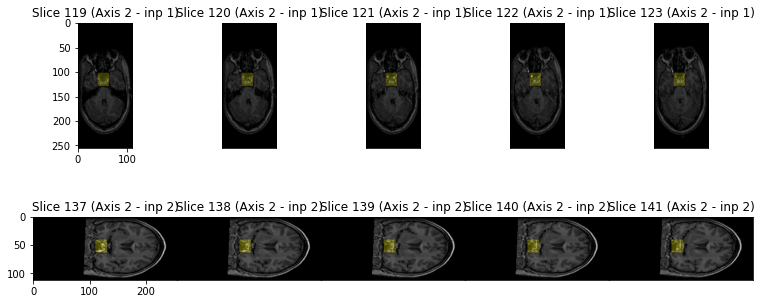

In [52]:
from helpers.viz import viz_compare_inputs

input1 = (arr1, mk1)
input2 = (arr2, mk2)

for axis in range(3):
    viz_compare_inputs(input1, input2, axis=axis)

# Test/Cleanup

In [27]:
fnames = [Path(i[0]).parent for i in items]
#print(*fnames, sep="\n")

In [34]:
for fn in fnames:
    dirs = glob.glob(f"{fn}/*.nii")
    if len(dirs) != 2:
        print(len(dirs), *[Path(d).name[-30:] for d in dirs], sep="\n"); print("*"*50)

In [49]:
start = time.time()

matches = [len([f for f in glob.glob(f"{fn}/*.nii") if "las" in f]) for fn in fnames]


todo = [f for i,f in enumerate(fnames) if matches[i]==0]
done = [f for i,f in enumerate(fnames) if matches[i]==1]
mult = [f for i,f in enumerate(fnames) if matches[i]>1]

print(f"Corrected: {len(done)}, TODO: {len(todo)}, Dupl: {len(mult)}")

elapsed = time.time() - start
print(f"Elapsed: {elapsed:.2f} s")

Corrected: 335, TODO: 0, Dupl: 0
Elapsed: 0.02 s


# Get chunk

In [45]:
import os

try:
    taskid = int(os.getenv('SLURM_ARRAY_TASK_ID'))
except:
    taskid = 0
    
n_total = len(todo)

chunk_len = 330    
chunks    = [range(i,min(i+chunk_len, n_total)) for i in range(0, n_total, chunk_len)]

print(f"N_chunks = {len(chunks)}")
# print(f"Array Task ID: {taskid}")
# print(f"Array ID: {os.getenv('SLURM_ARRAY_TASK_ID')}")
# print(f"Job ID: {os.getenv('SLURM_JOB_ID')}")
#print(*chunks, sep="\n")

task_chunk = chunks[taskid]

N_chunks = 1


In [46]:
def read_corrected_n4(fn):
    #im_path = f"{fn}/corrected_n4.nii"
    nii_paths = glob.glob(f"{fn}/*corrected_n4.nii")
    im_path   = nii_paths[0] 
    return sitk.ReadImage(im_path, sitk.sitkFloat32)

def read_dcm(fn):
    im = sitk.ReadImage(sitk.ImageSeriesReader_GetGDCMSeriesFileNames(fn), sitk.sitkFloat32)
    return im

def read_nii(fn):
    im = sitk.ReadImage(fn, sitk.sitkFloat32)    
    return im

# dcm
    #reader = sitk.ImageSeriesReader()
    #dicom_names = reader.GetGDCMSeriesFileNames(fn)
    #reader.SetFileNames(dicom_names)
    #im = reader.Execute() 
    

# Process

In [47]:
todo_chunk = [todo[i] for i in task_chunk]
print(len(todo_chunk), *todo_chunk, sep="\n")

330
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50423/MP-RAGE/2000-01-01_00_00_00.0/S164630
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50417/MP-RAGE/2000-01-01_00_00_00.0/S164841
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50446/MP-RAGE/2000-01-01_00_00_00.0/S165420
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50375/MP-RAGE/2000-01-01_00_00_00.0/S165252
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50378/MP-RAGE/2000-01-01_00_00_00.0/S165021
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50388/MP-RAGE/2000-01-01_00_00_00.0/S165450
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50406/MP-RAGE/2000-01-01_00_00_00.0/S164885
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50405/MP-RAGE/2000-01-01_00_00_00.0/S164788
/gpfs/data/oermannla

In [48]:
# from FAIMED3D 02_preprocessing
# and https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html

count = 0
for mr_path in todo_chunk: 
    
    start = time.time()
    
    # print
    print(count, mr_path, flush=True)
    count += 1
    
    # Read in image
    try:
        inputImage = read_corrected_n4(mr_path)
        
        # correct
        corrected_image = sitk.DICOMOrient(inputImage, "LAS")

        # write image
        corrected_fn = f"{mr_path}/las_corrected_n4.nii"
        sitk.WriteImage(corrected_image, corrected_fn)

        elapsed = time.time() - start
        print(f"Elapsed: {elapsed:0.2f} s")
    
    except Exception as e:
        print("Skipped: ", mr_path)
        print(e)
        #inputImage = read_dcm(mr_path) 
    

0 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50423/MP-RAGE/2000-01-01_00_00_00.0/S164630
Elapsed: 0.20 s
1 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50417/MP-RAGE/2000-01-01_00_00_00.0/S164841
Elapsed: 0.18 s
2 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50446/MP-RAGE/2000-01-01_00_00_00.0/S165420
Elapsed: 0.53 s
3 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50375/MP-RAGE/2000-01-01_00_00_00.0/S165252
Elapsed: 0.21 s
4 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50378/MP-RAGE/2000-01-01_00_00_00.0/S165021
Elapsed: 0.19 s
5 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50388/MP-RAGE/2000-01-01_00_00_00.0/S165450
Elapsed: 0.21 s
6 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50406/MP-RAGE/2000-01-01_00_00_00.0/S164885
Elapsed: 0.20 s
7 /gpfs/data/oermann

Elapsed: 0.51 s
59 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50447/MP-RAGE/2000-01-01_00_00_00.0/S165261
Elapsed: 0.52 s
60 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50410/MP-RAGE/2000-01-01_00_00_00.0/S164941
Elapsed: 0.19 s
61 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50317/MP-RAGE/2000-01-01_00_00_00.0/S165101
Elapsed: 0.20 s
62 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50339/MP-RAGE/2000-01-01_00_00_00.0/S165279
Elapsed: 0.20 s
63 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50315/MP-RAGE/2000-01-01_00_00_00.0/S164480
Elapsed: 0.20 s
64 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50350/MP-RAGE/2000-01-01_00_00_00.0/S165354
Elapsed: 0.19 s
65 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50338/MP-RAGE/2000-01-01_00_00_00.0/S165271
Elapsed: 0.20

Elapsed: 0.19 s
117 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50347/MP-RAGE/2000-01-01_00_00_00.0/S164844
Elapsed: 0.18 s
118 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50325/MP-RAGE/2000-01-01_00_00_00.0/S165116
Elapsed: 0.20 s
119 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50323/MP-RAGE/2000-01-01_00_00_00.0/S164313
Elapsed: 0.22 s
120 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50344/MP-RAGE/2000-01-01_00_00_00.0/S165226
Elapsed: 0.20 s
121 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50245/MP-RAGE/2000-01-01_00_00_00.0/S166099
Elapsed: 0.28 s
122 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50246/MP-RAGE/2000-01-01_00_00_00.0/S166107
Elapsed: 0.28 s
123 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50263/MP-RAGE/2000-01-01_00_00_00.0/S166098
Elapse

Elapsed: 0.17 s
175 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50260/MP-RAGE/2000-01-01_00_00_00.0/S166110
Elapsed: 0.26 s
176 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50304/MP-RAGE/2000-01-01_00_00_00.0/S165165
Elapsed: 0.20 s
177 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50259/MP-RAGE/2000-01-01_00_00_00.0/S166122
Elapsed: 0.26 s
178 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50300/MP-RAGE/2000-01-01_00_00_00.0/S164411
Elapsed: 0.20 s
179 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50267/MP-RAGE/2000-01-01_00_00_00.0/S166144
Elapsed: 0.28 s
180 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312/50306/MP-RAGE/2000-01-01_00_00_00.0/S164942
Elapsed: 0.21 s
181 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50201/MP-RAGE/2000-01-01_00_00_00.0/S164577
Elapse

Elapsed: 0.21 s
233 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50051/MP-RAGE/2000-01-01_00_00_00.0/S164869
Elapsed: 0.23 s
234 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50119/MP-RAGE/2000-01-01_00_00_00.0/S165298
Elapsed: 0.26 s
235 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50128/MP-RAGE/2000-01-01_00_00_00.0/S164908
Elapsed: 0.22 s
236 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50041/MP-RAGE/2000-01-01_00_00_00.0/S164886
Elapsed: 0.25 s
237 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50148/MP-RAGE/2000-01-01_00_00_00.0/S165614
Elapsed: 0.21 s
238 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50014/MP-RAGE/2000-01-01_00_00_00.0/S164678
Elapsed: 0.25 s
239 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50057/MP-RAGE/2000-01-01_00_00_00.0/S164909
Elapse

Elapsed: 0.21 s
291 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50042/MP-RAGE/2000-01-01_00_00_00.0/S164811
Elapsed: 0.22 s
292 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50105/MP-RAGE/2000-01-01_00_00_00.0/S165043
Elapsed: 0.23 s
293 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/MP-RAGE/2000-01-01_00_00_00.0/S164445
Elapsed: 0.26 s
294 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50006/MP-RAGE/2000-01-01_00_00_00.0/S165414
Elapsed: 0.28 s
295 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50133/MP-RAGE/2000-01-01_00_00_00.0/S165429
Elapsed: 0.26 s
296 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50049/MP-RAGE/2000-01-01_00_00_00.0/S164545
Elapsed: 0.26 s
297 /gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50007/MP-RAGE/2000-01-01_00_00_00.0/S165121
Elapse

In [ ]:
print("Done.")

In [ ]:
#print("Uncorrected: ", *uncorrected, sep="\n")

#os.listdir(uncorrected[0])
#uncorrected_nii = [os.path.join(f, os.listdir(f)[0]) for f in uncorrected]
#uncorrected_nii

# Very strange
# os.remove('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/._ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii')

# # delete multiple
# for f in multiple:
#     nii_paths = glob.glob(f"{f}/*corrected_n4_corrected_n4.nii")
#     for p in nii_paths:
#         os.remove(p)

# process uncorrected
# from FAIMED3D 02_preprocessing
# and https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html

# print("tot ", len(uncorrected))

# uncorrected_nii = [os.path.join(f, os.listdir(f)[0]) for f in uncorrected]

# count = 0
# for mr_path in uncorrected_nii: 
#     # print
#     print(count, mr_path, flush=True)
#     count += 1
    
#     # Read in image
#     inputImage = sitk.ReadImage(mr_path, sitk.sitkFloat32)
    
#     # Mask the head to estimate bias
#     maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)
    
#     # Set corrector
#     corrector = sitk.N4BiasFieldCorrectionImageFilter()
#     corrector.SetMaximumNumberOfIterations([3] * 3)
#     corrected_image = corrector.Execute(inputImage, maskImage)

#     # write image
#     corrected_fn = mr_path[:-4] + "_corrected_n4.nii"
#     sitk.WriteImage(corrected_image, corrected_fn)